#### 将原始数据转换成utf-8编码，防止后续出现各种编码问题
#### 由于原始数据比较大，在分词与过滤阶段会比较慢，这里我们选择了原始数据中的1K个
#### 这里的操作是实现csv文件的打开以及写入一行数据，首先是导入csv模块，（如果没有安装csv模块，可以参考模块的安装方式 
#### 包括pip 和 easy_install） 
#### 然后，使用csv的open函数以w（写入）方式打开，如果该csv文件不存在 则会在相对目录中创建一个csv文件。
#### 然后实例化一个写入对象writer，
#### 最后是使用writerow函数写入一条记录。

 ## 1、训练集编码转换

In [1]:
import csv    #逗号分隔值 Comma-Separated Values

#原始数据存储位置
data_path = '/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/user_tag_query.10W.TRAIN'
#生成数据路径
csvfile = open(data_path + '-1k.csv', 'w')
writer = csv.writer(csvfile)
writer.writerow(['ID', 'Age', 'Gender', 'Education', 'QueryList'])

#转换成utf-8编码的格式
with open(data_path, 'r', encoding='gb18030', errors='ignore') as f:
    lines = f.readlines()
    for line in lines[:1000]:
        try:
            #strip(rm)  当rm为空时，默认删除空白符（包括'\n', '\r',  '\t',  ' ')         
            line.strip()
            # split() 方法通过指定分隔符对字符串进行分割并返回一个列表，
            # 默认分隔符为所有空字符，包括空格、换行(\n)、制表符(\t)等
            data = line.split('\t')
            writedata = [data[0], data[1], data[2], data[3]]
            querystr = ''
            data[-1] = data[-1][:-1]
#             print(data[4:])
            for d in data[4:]:
                try:
                    cur_str = d.encode('utf8')
#                     print(cur_str)
                    cur_str = cur_str.decode('utf8')
#                     print(cur_str)
                    querystr += cur_str + '\t'
                except:
                    continue
#                     print(data[0][0:10])
            querystr = querystr[: -1]
#             print(querystr)
            writedata.append(querystr)
#             print(writedata)
#             print('*' * 80)
            writer.writerow(writedata)
          
        except:    
            continue
#     print(writedata)
      

## 2、测试集编码转换

In [5]:
import csv
data_path = '/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/user_tag_query.10W.TEST'

csvfile = open(data_path + '-1k.csv', 'w')
writer = csv.writer(csvfile)
writer.writerow(['ID', 'QueryList'])
with open(data_path, 'r',encoding='gb18030',errors='ignore') as f:
    lines = f.readlines()
    for line in lines[0:1000]:
        try:
            line.strip()
            data = line.split("\t")
            writedata = [data[0]]
            querystr = ''
            data[-1]=data[-1][:-1]
#             print(data[1:])
            for d in data[1:]:
                try:                  
                    cur_str = d.encode('utf8')
                    cur_str = cur_str.decode('utf8')
                    querystr += cur_str + '\t'               
                except:
                    #print (data[0][0:10])
                    continue
            querystr = querystr[:-1]
#             print(querystr)
            writedata.append(querystr)
#             print(writedata)
            writer.writerow(writedata)
        except:
            #print (data[0][0:20])
            continue

## 3、生成对应的数据表

In [6]:
import pandas as pd

#编码转换完成的数据，取的是1W的子集
trainname = '/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/user_tag_query.10W.TRAIN-1k.csv'
testname = '/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/user_tag_query.10W.TEST-1k.csv'

data = pd.read_csv(trainname,encoding='utf8')
print (data.info())

# 分别生成三种标签数据（性别，年龄，学历）
data.Age.to_csv("/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/train_age.csv", index=False)
data.Gender.to_csv("/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/train_gender.csv", index=False)
data.Education.to_csv("/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/train_education.csv", index=False)
# #将搜索数据单独拿出来
data.QueryList.to_csv("/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/train_querylist.csv", index=False)

data = pd.read_csv(testname,encoding='utf8')
print (data.info())
#测试数据
data.QueryList.to_csv("/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/test_querylist.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
ID           1000 non-null object
Age          1000 non-null int64
Gender       1000 non-null int64
Education    1000 non-null int64
QueryList    1000 non-null object
dtypes: int64(3), object(2)
memory usage: 39.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
ID           1000 non-null object
QueryList    1000 non-null object
dtypes: object(2)
memory usage: 15.7+ KB
None


## 对用户的搜索数据进行分词与词性过滤

## 4、训练集操作

In [8]:
import pandas as pd
import jieba
import jieba.analyse
import jieba.posseg
import time
import os, sys

def input(trainname):
    traindata = []
    with open(trainname, 'rb') as f:
        line = f.readline()   #读入数据，返回以行为单位的字符串
        count = 0
        while line:
            try:
                traindata.append(line)
                count += 1
            except:
                print('error:   line:%s,   count:%s'%(line, count))
            line = f.readline()
    return traindata

start_time = time.clock()

filepath = '/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/train_querylist.csv'
QueryList = input(filepath)
writepath = '/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/train_querylist_writefile-1k.csv'
csvfile = open(writepath, 'w')

POS = {}
# print(QueryList)
for i in range(len(QueryList)):
#     print(i)
    if i % 100  == 0 and i >= 100:
        print(i, 'finished')
    s = []
    str = ''
    words = jieba.posseg.cut(QueryList[i]) #带有词性的精确分词模式
    allowPOS = ['n', 'v', 'j']
#     print(words)
    for word , flag in words:
#         print(word, flag)
        POS[flag] = POS.get(flag, 0) + 1  #是统计字典POS里面的每个文本属性出现的次数
#         print(flag[0],word)
        if (flag[0] in allowPOS) and len(word) >=2:
            str += word + ' '
#     print(str)    
            
# print(POS)    
    cur_str = str.encode('utf8')
    cur_str = cur_str.decode('utf8')
    s.append(cur_str)
    
    csvfile.write(' '.join(s) + '\n') #拼接词，写入csv文件
csvfile.close()
# pd.read_csv('/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/test_querylist_writefile-1w.csv')
end_time = time.clock()
print('total time: %f s'%(end_time - start_time))



100 finished
200 finished
300 finished
400 finished
500 finished
600 finished
700 finished
800 finished
900 finished
total time: 91.378115 s


## 5、测试集操作

In [7]:
import pandas as pd
import jieba
import jieba.analyse
import jieba.posseg
import time
import os, sys

def input(trainname):
    traindata = []
    with open(trainname, 'rb') as f:
        line = f.readline() #读入数据，返回以行为单位的字符串
        count = 0
        while line:
            try:
                traindata.append(line)
                count += 1
            except:
                print('error:   line:%s,   count:%s'%(line, count))
            line = f.readline()
    return traindata

start_time = time.clock()

filepath = '/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/test_querylist.csv'
QueryList = input(filepath)
writepath = '/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/test_querylist_writefile-1k.csv'
csvfile = open(writepath, 'w')

POS = {}
# print(QueryList)
for i in range(len(QueryList)):
#     print(i)
    if i % 100  == 0 and i >= 100:
        print(i, 'finished')
    s = []
    str = ''
    words = jieba.posseg.cut(QueryList[i]) #带有词性的精确分词模式
    allowPOS = ['n', 'v', 'j']
#     print(words)
    for word , flag in words:
#         print(word, flag)
        POS[flag] = POS.get(flag, 0) + 1  #是统计字典POS里面的每个文本属性出现的次数
#         print(flag[0],word)
        if (flag[0] in allowPOS) and len(word) >=2:
            str += word + ' '
#     print(str)    
            
# print(POS)    
    cur_str = str.encode('utf8')
    cur_str = cur_str.decode('utf8')
    s.append(cur_str)
    
    csvfile.write(' '.join(s) + '\n') #拼接词，写入csv文件
csvfile.close()
# pd.read_csv('/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/test_querylist_writefile-1w.csv')
end_time = time.clock()
print('total time: %f s'%(end_time - start_time))


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/rk/6v6c81ps2_vdd7tkz09vkk180000gn/T/jieba.cache
Loading model cost 1.280 seconds.
Prefix dict has been built succesfully.


100 finished
200 finished
300 finished
400 finished
500 finished
600 finished
700 finished
800 finished
900 finished
total time: 87.949349 s


### 使用Gensim库建立word2vec词向量模型
### 参数定义：
-  sentences：可以是一个list
-  sg： 用于设置训练算法，默认为0，对应CBOW算法；sg=1则采用skip-gram算法。
-  size：是指特征向量的维度，默认为100。大的size需要更多的训练数据,但是效果会更好. 推荐值为几十到几百。
-  window：表示当前词与预测词在一个句子中的最大距离是多少
-  alpha: 是学习速率
-  seed：用于随机数发生器。与初始化词向量有关。
-  min_count: 可以对字典做截断. 词频少于min_count次数的单词会被丢弃掉, 默认值为5
-  max_vocab_size: 设置词向量构建期间的RAM限制。如果所有独立单词个数超过这个，则就消除掉其中最不频繁的一个。每一千万个单词需要大约1GB的RAM。设置成None则没有限制。

-  workers参数控制训练的并行数。
-  hs: 如果为1则会采用hierarchica·softmax技巧。如果设置为0（defau·t），则negative sampling会被使用。
-  negative: 如果>0,则会采用negativesamp·ing，用于设置多少个noise words
-  iter： 迭代次数，默认为5

## 6、建立训练集词向量模型

In [36]:
from gensim.models import word2vec

#将数据变换成list of list 格式  列表里元素是列表
train_path = '/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/train_querylist_writefile-1k.csv' 
with open(train_path, 'r', encoding='utf8') as f:
    my_list = []
    lines = f.readlines() #读入数据，返回以行为单位的列表
#     print(lines)
    for line in lines:
#         print(line)
#         print('*' * 10)
        cur_list = []
        line = line.strip()  ##strip(rm)  当rm为空时，默认删除空白符（包括'\n', '\r',  '\t',  ' ') 
        # split() 方法通过指定分隔符对字符串进行分割并返回一个列表，
        # 默认分隔符为所有空字符，包括空格、换行(\n)、制表符(\t)等
        data = line.split(' ')
        for d in data:
            cur_list.append(d)
        my_list.append(cur_list)
    
    #size: 特征向量维度， window: 当前词与预测词在一个句子中的最大距离是多少， workers: 参数控制训练的并行数
    model = word2vec.Word2Vec(my_list, size=300, window=10, workers=4)
    savepath = '/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/1k_word2vec_' + '300_train'+'.model' #保存model的路径
    model.save(savepath)
    

        
        

## 7、建立测试集词向量模型

In [38]:
from gensim.models import word2vec

#将数据变换成list of list 格式  列表里元素是列表
train_path = '/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/test_querylist_writefile-1k.csv' 
with open(train_path, 'r', encoding='utf8') as f:
    my_list = []
    lines = f.readlines() #读入数据，返回以行为单位的列表
#     print(lines)
    for line in lines:
#         print(line)
#         print('*' * 10)
        cur_list = []
        line = line.strip()  ##strip(rm)  当rm为空时，默认删除空白符（包括'\n', '\r',  '\t',  ' ') 
        # split() 方法通过指定分隔符对字符串进行分割并返回一个列表，
        # 默认分隔符为所有空字符，包括空格、换行(\n)、制表符(\t)等
        data = line.split(' ')
        for d in data:
            cur_list.append(d)
        my_list.append(cur_list)
    
    #size: 特征向量维度， window: 当前词与预测词在一个句子中的最大距离是多少， workers: 参数控制训练的并行数
    model = word2vec.Word2Vec(my_list, size=300, window=10, workers=4)
    savepath = '/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/1k_word2vec_' + '300_test'+'.model' #保存model的路径
    model.save(savepath)
    

        
        

In [15]:
model.wv.most_similar_cosmul('美国')

[('发展', 0.9999012351036072),
 ('酒吧', 0.9998672008514404),
 ('自学', 0.9998582005500793),
 ('手机号码', 0.999855637550354),
 ('二氧化碳', 0.9998469352722168),
 ('天宫', 0.9998432993888855),
 ('状态', 0.999841570854187),
 ('位置', 0.999838650226593),
 ('牙齿', 0.9998380541801453),
 ('海尔', 0.9998377561569214)]

In [153]:
model.wv.most_similar_cosmul('北京')

[('图片', 0.9999827742576599),
 ('手机', 0.999982476234436),
 ('意思', 0.9999820590019226),
 ('视频', 0.9999817609786987),
 ('时候', 0.9999815225601196),
 ('电影', 0.9999814629554749),
 ('下载', 0.9999814033508301),
 ('中国', 0.9999808669090271),
 ('时间', 0.999980092048645),
 ('电脑', 0.9999799728393555)]

# 加载训练好的word2vec模型，求用户搜索结果的平均向量

## 8、训练集用户搜索结果的平均向量   构造用户特征

In [37]:
import numpy as np
import gensim
file_name = '/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/train_querylist_writefile-1k.csv'
cur_model = gensim.models.Word2Vec.load('/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/1k_word2vec_300_train.model')
with open(file_name, 'r') as f:
    cur_index = 0
    lines = f.readlines()  #读入数据，返回以行为单位的列表
    print(len(lines))
    doc_cev = np.zeros((len(lines), 300)) # 整个样本接近1000行，300列（特征值）
    for line in lines:
        word_vec = np.zeros((1, 300))  # 每个样本 1行300列（特征值）
        line = line.strip()
        words = line.split(' ')
        word_num = 0
        
        #求模型的平均向量
        for word in words:
            if word in cur_model:
                word_num += 1
                word_vec += np.array([cur_model[word]])
        doc_cev[cur_index] = word_vec / float(word_num)
        cur_index += 1
        
doc_cev.shape
            
    

1000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(1000, 300)

In [68]:
print(doc_cev)

[[ 0.06832488  0.32596283 -0.09624156 ...  0.05742462  0.06932377
  -0.04830669]
 [ 0.0654227   0.30954785 -0.11374375 ...  0.05855927  0.08596156
  -0.02197708]
 [ 0.06700595  0.29274093 -0.00853721 ...  0.02656076 -0.01436163
  -0.13834066]
 ...
 [ 0.06897872  0.25913593 -0.00630648 ...  0.029223   -0.01575242
  -0.11401732]
 [ 0.10010176  0.28888933 -0.00363653 ...  0.00362836 -0.02017755
  -0.12775131]
 [ 0.06659681  0.35612158 -0.08979584 ...  0.06863098  0.06129632
  -0.07283477]]


In [18]:
# astype()数据类型转换
# Load data from a text file，Each row in the text file must have the same number of values.

genderlabel = np.loadtxt(open('/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/train_gender.csv', 'r')).astype(int)
genderlabel.shape

(1000,)

In [26]:
educationlabel = np.loadtxt(open('/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/train_education.csv', 'r')).astype(int)
educationlabel.shape

(1000,)

In [23]:
agelabel = np.loadtxt(open('/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/train_age.csv', 'r')).astype(int)
agelabel.shape

(1000,)

In [ ]:
 返回数组a中非零元素的索引值数组。

（1）只有a中非零元素才会有索引值，那些零值元素没有索引值； 
（2）返回的索引值数组是一个2维tuple数组，该tuple数组中包含一维的array数组。其中，一维array向量的个数与a的维数是一致的。 
（3）索引值数组的每一个array均是从一个维度上来描述其索引值。比如，如果a是一个二维数组，则索引值数组有两个array，第一个array从行维度来描述索引值；第二个array从列维度来描述索引值。 
（4） 该np.transpose(np.nonzero(x)) 
函数能够描述出每一个非零元素在不同维度的索引值。 
（5）通过a[nonzero(a)]得到所有a中的非零值

In [125]:
import numpy as np
a = np.array([[0, 4, 1],
              [1, 0, 3]])
b = np.nonzero(a)
b

(array([0, 0, 1, 1]), array([1, 2, 0, 2]))

In [21]:
print(doc_cev)

[[-0.14353593  0.06837349  0.36230402 ... -0.25978045  0.25332598
  -0.12277648]
 [-0.09390668 -0.05783897  0.40738428 ... -0.34815916  0.21642885
   0.12143648]
 [-0.14892906 -0.01945369  0.16526717 ... -0.18926779  0.09193724
  -0.17401668]
 ...
 [ 0.37011939  0.0754554   0.35519172 ...  0.03905357  0.49179145
  -0.763993  ]
 [-0.06460512  0.26299776  0.58868026 ... -0.20940584  0.4988322
  -0.61018339]
 [-0.31004154 -0.05644561  0.26388837 ... -0.27034968  0.06209313
   0.06773573]]


## 9、过滤0值

In [27]:


def removezero(x, y):
        nozero = np.nonzero(y)
        y = y[nozero]
        x = np.array(x)
        x = x[nozero]
        return x, y
gender_train, genderlabel = removezero(doc_cev, genderlabel)
age_train, agelabel = removezero(doc_cev, agelabel)
education_train, educationlabel = removezero(doc_cev, educationlabel)
print (gender_train.shape,genderlabel.shape)
print (age_train.shape,agelabel.shape)
print (education_train.shape,educationlabel.shape)


(978, 300) (978,)
(981, 300) (981,)
(916, 300) (916,)


## 10、绘制函数， 以性别为例， 绘制混淆矩阵

In [29]:
import matplotlib.pyplot as plt
# Python的内建模块itertools提供了非常有用的用于操作迭代对象的函数。
import itertools

#打印并绘制混淆矩阵
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()  #为图添加彩条标值
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2
    
    # product 在n个数组中每个数组选一个值组成的所有序列
    #text(0.5, 0.5,'matplotlib', 
    #    horizontalalignment='center',
    #    verticalalignment='center',
    #    transform=ax.transAxes)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i, j],  #在轴上添加文本
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()   #自动调节 subplot 参数进行指定填充
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

## 11、测试集用户搜索结果的平均向量

In [39]:
import numpy as np
import gensim
file_name = '/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/test_querylist_writefile-1k.csv'
cur_model = gensim.models.Word2Vec.load('/Users/peijian/Downloads/python/数据分析&机器学习/数据挖掘案例/用户画像/1k_word2vec_300_test.model')
with open(file_name, 'r') as f:
    cur_index = 0
    lines = f.readlines()  #读入数据，返回以行为单位的列表
    print(len(lines))
    doc_cev = np.zeros((len(lines), 300)) # 整个样本接近1000行，300列（特征值）
    for line in lines:
        word_vec = np.zeros((1, 300))  # 每个样本 1行300列（特征值）
        line = line.strip()
        words = line.split(' ')
        word_num = 0
        
        #求模型的平均向量
        for word in words:
            if word in cur_model:
                word_num += 1
                word_vec += np.array([cur_model[word]])
        doc_cev[cur_index] = word_vec / float(word_num)
        cur_index += 1    

1000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [40]:
doc_cev.shape

(1000, 300)

In [47]:
doc_cev[5][0:12]

array([ 0.07248188,  0.28281311, -0.05221067, -0.02591032,  0.12063755,
        0.12275833,  0.00536025,  0.18469497, -0.20882016, -0.26221179,
        0.27646158, -0.17151399])

## 12、建立一个基础预测模型

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.5408163265306123
Recall metric in the testing dataset:  0.20930232558139536
accuracy metric in the testing dataset:  0.5408163265306123


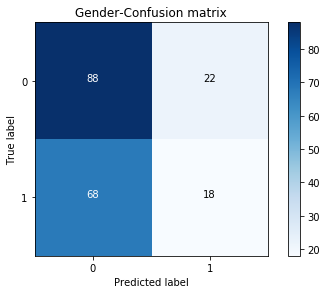

In [48]:
from sklearn.linear_model import LogisticRegression  #逻辑回归
from sklearn.metrics import confusion_matrix         #混淆矩阵
from sklearn.cross_validation import train_test_split  #数据集的切分

# train_test_split函数用于将矩阵随机划分为训练子集和测试子集，并返回划分好的训练集测试集样本和训练集测试集标签。
# 格式：
# X_train,X_test, y_train, y_test =cross_validation.train_test_split(train_data,train_target,test_size=0.3, random_state=0)
# 参数解释：
# train_data：被划分的样本特征集
# train_target：被划分的样本标签
# test_size：如果是浮点数，在0-1之间，表示样本占比；如果是整数的话就是样本的数量
# random_state：是随机数的种子

# print (gender_train.shape,genderlabel.shape)
# print (age_train.shape,agelabel.shape)
# print (education_train.shape,educationlabel.shape)

#(978, 300) (978,)
#(981, 300) (981,)
#(916, 300) (916,)

X_train, X_test, y_train, y_test = train_test_split(gender_train,genderlabel,test_size = 0.2, random_state = 0)

LR_model = LogisticRegression()

LR_model.fit(X_train,y_train)
y_pred = LR_model.predict(X_test)
print (LR_model.score(X_test,y_test))

cnf_matrix = confusion_matrix(y_test,y_pred) 

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

print("accuracy metric in the testing dataset: ", (cnf_matrix[1,1]+cnf_matrix[0,0])/(cnf_matrix[0,0]+cnf_matrix[1,1]+cnf_matrix[1,0]+cnf_matrix[0,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Gender-Confusion matrix')
plt.show() 

0.5816326530612245
Recall metric in the testing dataset:  0.2558139534883721
accuracy metric in the testing dataset:  0.5816326530612245


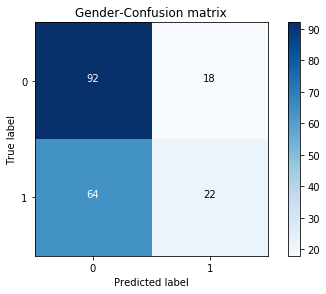

In [49]:
from sklearn.ensemble import RandomForestClassifier  #随机森林分类
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(gender_train,genderlabel,test_size = 0.2, random_state = 0)

RF_model = RandomForestClassifier(n_estimators=100,min_samples_split=5,max_depth=10)

RF_model.fit(X_train,y_train)
y_pred = RF_model.predict(X_test)
print (RF_model.score(X_test,y_test))

cnf_matrix = confusion_matrix(y_test,y_pred)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

print("accuracy metric in the testing dataset: ", (cnf_matrix[1,1]+cnf_matrix[0,0])/(cnf_matrix[0,0]+cnf_matrix[1,1]+cnf_matrix[1,0]+cnf_matrix[0,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Gender-Confusion matrix')
plt.show()

## 13、堆叠模型

In [50]:
from sklearn.svm import SVC     #支持向量机
from sklearn.naive_bayes import MultinomialNB    #朴素贝叶斯分类器MultinomialNB
clf1 = RandomForestClassifier(n_estimators=100,min_samples_split=5,max_depth=10)    #随机森林
clf2 = SVC()
clf3 = LogisticRegression()    #逻辑回归
basemodes = [
            ['rf', clf1],
            ['svm', clf2],
            ['lr', clf3]
            ]

In [55]:
print('X_train:',X_train.shape)
print('X_test:',X_test.shape)
print('y_train:',y_train)
len(basemodes)

X_train: (782, 300)
X_test: (196, 300)
y_train: [2 1 2 1 2 2 1 2 1 1 1 1 2 1 1 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 1 2 2 2 1 2 2
 2 2 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 2 2 2 2 2 1 1 2 2 1 1 2 1 2 2 2 1 1
 2 2 1 2 1 2 1 1 1 2 1 2 2 2 2 1 1 1 1 2 2 1 1 1 2 2 1 1 2 2 1 1 1 2 2 1 2
 1 2 1 1 2 2 1 1 1 1 2 1 1 2 1 2 1 2 1 1 2 1 1 2 2 1 1 1 2 1 2 2 2 2 1 1 1
 1 2 1 2 1 2 2 1 2 2 2 1 1 1 1 1 1 2 2 1 2 1 2 2 2 1 1 2 1 1 2 1 1 1 1 1 2
 1 1 2 1 1 1 1 2 1 2 1 2 1 1 2 1 1 1 1 1 1 1 1 1 2 1 2 2 1 2 1 1 2 2 2 1 1
 2 1 2 2 2 2 2 1 2 2 1 1 2 1 1 1 2 1 2 1 1 1 1 1 2 1 1 2 1 1 1 1 2 1 2 1 1
 2 2 1 1 1 2 2 1 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 1 1 2 1 1
 1 1 1 2 1 1 1 1 1 1 1 2 1 1 2 1 2 1 2 1 1 2 2 2 2 1 2 2 1 2 1 2 1 2 2 2 1
 1 1 1 1 1 2 1 1 2 2 1 2 2 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 2 2 2 1 1 1 2 2 1
 1 2 1 2 1 1 2 1 1 1 1 1 1 2 2 1 2 2 1 1 1 2 1 2 2 1 1 1 1 2 2 2 1 1 1 1 1
 2 1 1 2 1 1 2 2 2 2 2 2 2 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 2 1 1 1 1 2 2 1
 2 1 1 1 1 2 1 1 1 2 1 2 2 2 2 2 2 1 2 2 1 1 1 2 1 2

3

In [73]:
# 交叉验证
# 在同一个数据集上学习算法的参数和进行预测是方法性的错误。很有可能会导致Overfitting。
# 避免过拟合的常用方法是将一部分数据作为测试集，用以对算法进行测试
from sklearn.cross_validation import KFold, StratifiedKFold   
models = basemodes

#X_train, X_test, y_train, y_test
#len(y_train)指代样本数，n_folds指代将数据集分成多少份且做几次验证试验
folds = list(KFold(len(y_train), n_folds=5, random_state=0))
print (len(folds))

#X_train.shape: (782, 300)
#X_test.shape: (196, 300)
#len(model): 3
# for i, (j, k) in enumerate(folds):
#         print('j',j[0:10])
#         print('k',k[0:10])
S_train = np.zeros((X_train.shape[0], len(models)))
S_test = np.zeros((X_test.shape[0], len(models)))

for i, bm in enumerate(models):
    clf = bm[1]

    #S_test_i = np.zeros((y_test.shape[0], len(folds)))
    for j, (train_idx, test_idx) in enumerate(folds):
        X_train_cv = X_train[train_idx]
        y_train_cv = y_train[train_idx]
        X_val = X_train[test_idx]
        clf.fit(X_train_cv, y_train_cv)
        y_val = clf.predict(X_val)[:]
          
        S_train[test_idx, i] = y_val
    S_test[:,i] = clf.predict(X_test)

final_clf = RandomForestClassifier(n_estimators=100)
final_clf.fit(S_train,y_train)

print (final_clf.score(S_test,y_test))



5
0.5714285714285714
